In [1]:
%load_ext autoreload
%autoreload 2
%load_ext juliacall

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
from control_guided_nas import get_max_diam
from itertools import product
import pandas as pd
import numpy as np
import concurrent.futures
from tqdm import tqdm

systems = ["F1", "CC"]
latency = np.arange(0.001, 0.2, 0.001)
accuracy = np.arange(0.5, 1.0, 0.01)

rows = []

with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    print("Creating futures")
    futures_to_args = {}
    for argset in product(systems, latency, accuracy):
        s, l, a = argset
        futures_to_args[executor.submit(get_max_diam, l, 1 - a, s)] = argset
    
    print("Waiting for futures")
    with tqdm(total=len(futures_to_args)) as pbar:
        for future in concurrent.futures.as_completed(futures_to_args):
            diameter = future.result()
            rows.append([*futures_to_args[future], diameter])
            pbar.update(1)

# for sys in systems:
#     for l in latency:
#         for a in accuracy:
#             rows.append([l, a, sys, diam(l, a, sys)[1]])

df = pd.DataFrame(rows, columns=["latency", "accuracy", "system", "diameter"])
df

# Plotting
# for sys in ["F1", "CC"]:
#     for setup in ["l11_tcp", "l15_tcp", "l11_udp", "l15_udp"]:
#         plt.plot(range(1, 6), diameter[sys][setup], label=f"{sys} {setup}", marker="o", lw=4, markersize=15)
#     plt.xticks(range(1, 6), fontsize=15)
#     plt.yticks(fontsize=15)
#     plt.xlabel("Network loss (%)", fontsize=20)
#     plt.ylabel("Max diameter of reachable sets (m)", fontsize=20)
#     # plt.title("Reachability analysis with a simplified cruise control model", fontsize=18)
#     plt.legend(fontsize=15)
#     plt.show()

Creating futures
Waiting for futures


  0%|          | 0/19900 [00:00<?, ?it/s]


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

Process SpawnProcess-26:
Process SpawnProcess-25:
Process SpawnProcess-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process SpawnProcess-28:
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ctrl/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ctrl/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ctrl/lib/python3.13/concurrent/futures/process.py", line 242, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/ctrl/lib/python3.13/multiprocessing/queues.py", line 120, in get
    return _ForkingPickler.loads(res)
           ~~~~~~~~~~~~~~~~~~~~~^^^^^
AttributeError: Can't get attribute 'diam' on <module '__main__' 

In [3]:
df.to_csv("diameters_fixed.csv", index=False)

In [4]:
df = pd.read_csv("diameters_fixed.csv")

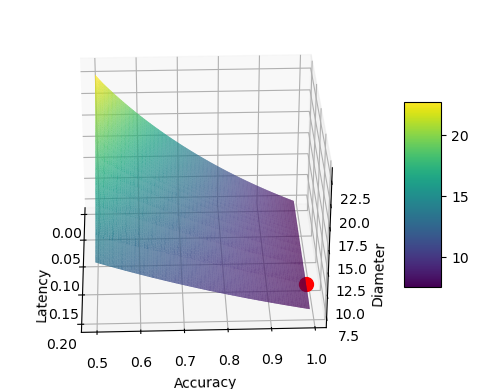

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

def plot_scan(df: pd.DataFrame, sysname: str):
    data = df[df['system'] == sysname]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    latency_vals = data['latency'].values
    accuracy_vals = data['accuracy'].values
    diameter_vals = data['diameter'].values
    minima = np.argmin(diameter_vals)

    surf = ax.plot_trisurf(latency_vals, accuracy_vals, diameter_vals, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    ax.scatter(latency_vals[minima], accuracy_vals[minima], diameter_vals[minima], s=100, marker='o', color='red')

    ax.set_xlabel('Latency')
    ax.set_ylabel('Accuracy')
    ax.set_zlabel('Diameter')

    def update(frame):
        ax.view_init(elev=30, azim=frame)
        return fig,

    ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50, blit=True)
    ani.save('rotating_surface.gif', writer=PillowWriter(fps=20))

    plt.show()

# Example usage
plot_scan(df, "CC")

KeyboardInterrupt: 

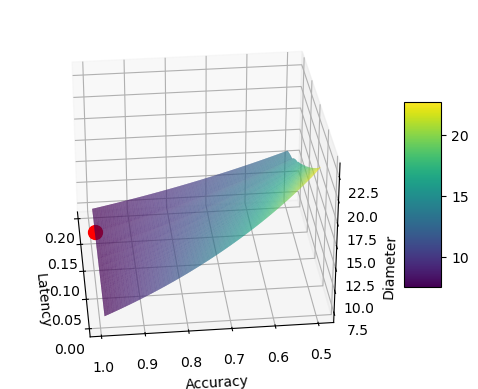

In [9]:
plot_scan(df, "CC")

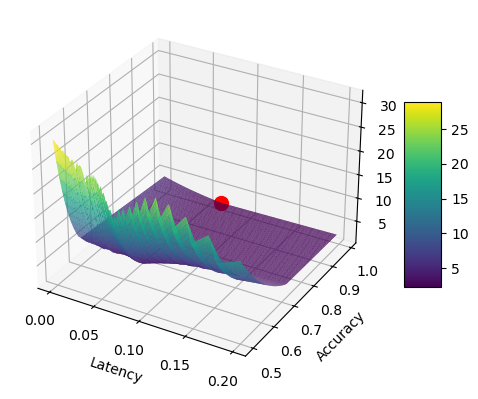

In [7]:
plot_scan(df, "F1")